Marine Phosphate Cycling and primary productivity
=================================================



## Notes:



-   This `Jupyter Notebook` contains text cells, and code cells.
-   You can edit the text cells using markdown syntax. Just double click this cell to try it out. When finished, press shift+enter.
-   You can execute the python code in each text cell by placing the cursor into a code-cell, and press shift+enter.
-   If you have more then one code cell, you need to execute them in sequential
    order since each cell depends on the output of the previous cell.



## Model structure



In the following, we use a two box ocean model. The surface box represents the `photic zone`  of the ocean, and the deep-box represents the `deep ocean` that is below the photic zone.  The mode approximates the `thermohaline circulation` by two fluxes, $F_u$ which describes the upwelling of deep water, and $F_d$ which describes the downwelling of surface water.

Marine primary productivity (i.e., photosynthesis) is typically limited by the availability of dissolved phosphate. In order to keep the model simple, we assume a linear relationship between the Phosphate concentration and the amount of `organic matter` that is produced by photosynthesis. Since we are only interested in Phosphate, there are no terms for organic matter (OM) production. However, since OM will eventually sink into the deep ocean, the organic bound Phosphate will also sink into the deep ocean. I will call this settling flux $F_{POP}$ which stands for "Particulate Organic Phosphate". So we can express  $F_{POP}$ as being proportional to the PO<sub>4</sub> concentration:

\begin{equation}\label{}
F_{POP} = [PO_4] \times \frac{V_S}{\tau}
\end{equation}

where $\tau$ is a constant, and $V_S$ is the volume of the surface box. Now, why the so complicated? Consider the definition of the residence time:

\begin{equation}\label{}
R_t = \frac{M}{F}
\end{equation}

if we re-arrange this, we get:

\begin{equation}\label{}
F = \frac{M}{R_t}
\end{equation}

which is the same as $F_{POP}$ equation above.  In other words, $\tau$ is the residence time of phosphate in the surface ocean.  Neat!

We can now describe the equations that govern [PO<sub>4</sub>] in the surface and deep ocean

![img](./images/mpc.png)

Similar to the previous  model, our fluxes are not static (with the exception of the weathering flux). $F_u$ and $F_b$ depend on the velocity of thermohaline circulation, and the respective phosphate concentration in each box:

\begin{equation}\label{}
F_u = thc \times [PO_4]_{D}
\end{equation}

where `thc` denotes the velocity of  the thermohaline circulation, and $[PO_4]_D$ the concentration in the deep ocean.  A similar equation can be written for $F_d$. 



#### The burial flux



Most of the sinking organic matter will be `remineralized` in the deep
ocean. For our model, we sill assume that the remineralization efficiency is
about 99% percent. I.e., only 1% percent of the marine export productivity is
buried in the sediments. We can thus write:

\begin{equation}\label{}
F_b = F_{POP} \times (1 -\epsilon)
\end{equation}

where $\epsilon$ denotes the burial efficiency (i.e., 99% = 0.99). 



### Model Equations



For the PO4 concentration in the surface ocean, we can write:

\begin{equation}\label{}
\frac{[PO_{4}]_{S}}{dt} = F_w + [PO_{4}]_{D} \times thc - [PO_{4}]_{S} \times thc - [PO_{4}]_{S} \times \frac{V_S}{\tau}
\end{equation}

and for the deep ocean:

\begin{equation}\label{}
\frac{[PO_4]_S}{dt} =  [PO_4]_S \times \frac{V_S}{\tau} \times \epsilon + [PO_4]_{S} \times thc - [PO_4]_{D} \times thc
\end{equation}

Note that both equations depend on each other, i.e., we need to know the result from one equation to calculate the result of the other equation (i.e., coupled differential equations).



## Model boundary conditions



As before, use your notes to find the missing boundary condition data below, and edit the code accordingly. Then execute the code cell, and verify the values in the print out
before you continue.

Note if your values are way off, the model will either not run, or run forever. So check that F<sub>r</sub> is between 1E3 and 2E3 mol/s, and that your surface ocean volume is between 20E15 and 40E15 m<sup>2</sup>, and the deep ocean volume is between 1E18 and 2E18 m<sup>3</sup>. THC must be between 20E6 and 40E6. If in doubt check with instructor.



In [2]:
"""
A simple P-cycle model, based on chapter 8 of Modeling Methods for the marine
sciences.

This model uses a 2 box ocean, and the P-export flux depends on the biological
productivity in the surface ocean
"""
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

F_r = 1.5e3*2  # River (weathering) flux of PO4 mol/s
tau = 1  # P residency time in surface ocean in years
r = 0.99  # remineralization efficiency
V = [30e15, 1.33e18]  # Volume of surface and deep box m^3
THC = 25e6  # m^3/s or 25 Sv = Sverdrup
C_0 = [1.5784e-4, 6.1e-03]  #
time = 4e6  # run time in years
show_deep_ocean_data = True # True or False
print(f"Vs = {V[0]:.2e} m^3, C_0_s = {C_0[0]:.2f} mol/m^3")
print(f"Vd = {V[1]:.2e} m^3, C_0_d = {C_0[1]:.2f} mol/m^3")
print(f"tau = {tau} yrs, r = {r:.2f}, run time = {time:.2e} yrs")

Vs = 3.00e+16 m^3, C_0_s = 0.00 mol/m^3
Vd = 1.33e+18 m^3, C_0_d = 0.01 mol/m^3
tau = 1 yrs, r = 0.99, run time = 4.00e+06 yrs


## Execute the model



Run the below code and you should see a graph describing how the marine PO<sub>4</sub> concentration changes with time.



tau = 1.000000 yrs, C_s = 3.16e-04 mol/m^2, C_d = 1.22e-02 mol/m^3


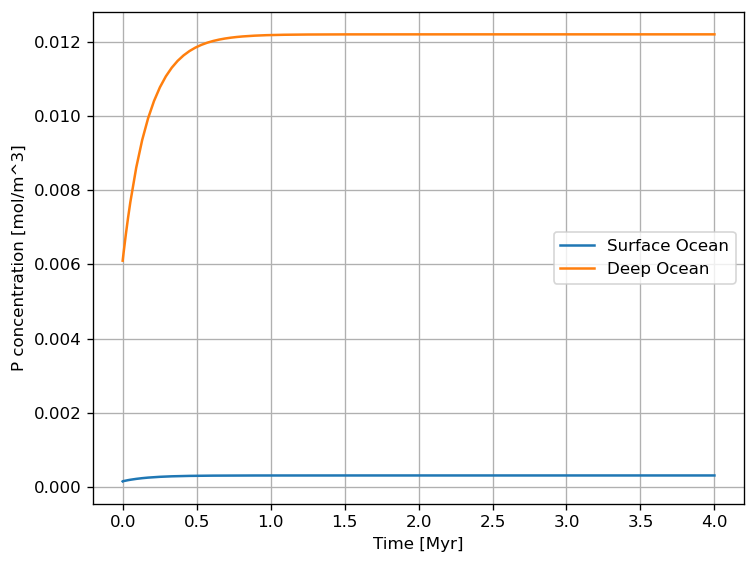

In [3]:
# some misc defintions
year_to_seconds = 60 * 60 * 24 * 365.2425  #
tau = tau * year_to_seconds  # convert to seconds
t_span = (0, time * year_to_seconds)  # model run time
p = (V, F_r, THC, tau, r)  # function arguments
max_step = t_span[1] / 100

def dCdt(t, C_0, V, F_r, THC, tau, r):
    """Calculate the change in concentration as function of time

    :param t: array, not used but must be present
    :param C_0: array of initial conditions (concentrations)
    :params V_s: Volume of surface ocean [m^3]
    :param V_d: Volume of deep ocean [m^3]
    :param F_r: River (weathering) flux of PO4 mol/s
    :param THC: Thermo haline circulation flux
    :param r: remineralization efficiency from 0 to 1
    :returns: array of dC/dt values

        The surface to deep ocean flux has two components:

            1. The dissolved PO4 that is removed via the thermohaline
               circulation, i.e., THC * C_s

            2. The particulate organic matter that sinks into the deep ocean and
               carries PO4 as as port of the cell structure.  This flux depends
               on the marine export productivity which is limited by the PO4
               concentratio, i.e., C_s* V / tau wher tau is a scaling factor
    """

    C_s = C_0[0]  # surface ocean concentration
    C_d = C_0[1]  # deep ocean concentration
    V_s = V[0]  # surface ocean volume
    V_d = V[1]  # deep ocean volume

    P = C_s * V_s / tau  # export productivity
    F_b = P * (1 - r)  # P burial
    F_s2d = THC * C_s  # Surface to deep ocean flux
    F_d2s = THC * C_d  # Deep to surface ocean flux

    # dC/dt surface ocean
    dCdt_s = (F_r + F_d2s - F_s2d - P) / V_s
    # dC/dt deep ocean
    dCdt_d = (F_s2d + P - F_d2s - F_b) / V_d

    return [dCdt_s, dCdt_d]

result = solve_ivp(  # integrate dC/dt
    dCdt,
    t_span,
    C_0,
    args=p,
    method="BDF",
    max_step=max_step,
)
t = result.t / year_to_seconds / 1e6  # time in Myr
C_s = result.y[0]  # surface box concentration in mol/m^3
C_d = result.y[1]  # deep box concentration in mol/m^3

print(
    f"tau = {tau/year_to_seconds:f} yrs, C_s = {C_s[-1]:.2e} mol/m^2, C_d = {C_d[-1]:.2e} mol/m^3"
)
fig, ax = plt.subplots()
ax.plot(t, C_s, color="C0", label="Surface Ocean")
if show_deep_ocean_data:
    ax.plot(t, C_d, color="C1", label="Deep Ocean")
ax.set_xlabel("Time [Myr]")
ax.set_ylabel("P concentration [mol/m^3]")
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

Now lets do some sanity checks. Calculate the residence time for the phosphate
in the deep ocean and check that it is around 609kyrs. If not, there is a
mistake in the boundary conditions.

